## Software Use Case

Use case of inferring if a llm/chatbot helps the software engineering team to be more productible. If it worths its cost.

### DAG Image

In [160]:
# IMPORTS
import os
from gurobipy import Model, GRB
import pandas as pd
import random
from typing import List, Dict, Tuple

os.chdir('/home/lawand/Experiments')

from utils.funcoes import generate_example, get_joaos_input
from causal_solver.Helper import Helper
from causal_solver.graph import Graph

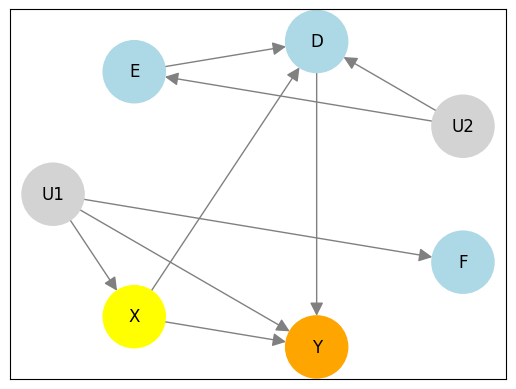

In [161]:
arestas = "U1 -> X, U1 -> Y, U1 -> F, U2 -> D, U2 -> E, X -> Y, X -> D, D -> Y, E -> D"
latents = ["U1", "U2"]
intervention=["X"]
target="Y"
input_path = "/home/lawand/Experiments/Experiments/Software/software_case.txt"
generate_example(arestas, latent=latents, intervention=intervention, target=target)
get_joaos_input(edges_str=arestas, latent=latents, file_path=input_path)


### Data Generation

In [162]:
random.seed(42)
SAMPLES = 100_000

U1_cardinality = 32
U2_cardinality = 8
X_cardinality = 2
Y_cardinality = 2
D_cardinality = 2
E_cardinality = 2
F_cardinality = 2

def func_U1_U2(u1_0, u1_1, u2_0=0.5, u2_1=0.5):
    U1_column = random.choices([0,1], weights=[u1_0, u1_1], k=SAMPLES)
    U2_column = random.choices([0,1], weights=[u2_0, u2_1], k=SAMPLES)
    return U1_column, U2_column

def func_F(parent): # u1
    funcf = []
    for p in parent:
        funcf.append(1 if not p else 0)
    return funcf

def func_E(parent): #u2
    funce = []
    for p in parent:
        funce.append(p)
    return funce

def func_X(parent): # u1
    funcx = []
    for p in parent:
            funcx.append(p)
    return funcx

def func_D(parents): # u2, e, x
    funcd = []
    for i in range(SAMPLES):
            u2 = parents[0][i]
            e = parents[1][i]
            x = parents[2][i]
            funcd.append(1 if (e or u2) ^ x else 0)
    return funcd


def func_Y(parents): # u1, x, d
    y = []
    for i in range(SAMPLES):
            u1 = parents[0][i]
            x = parents[1][i]
            d = parents[2][i]
            y.append(1 if (u1 or x) ^ d else 0)
    return y

In [163]:
test_name = "software_case"
dag: Graph = Graph.parse(file_path=input_path)
csv_path = ""
doX = 1
y_target_value = 1

u_probs = [
    [0.9, 0.1],
    [0.7, 0.3],
    [0.6, 0.4],
    [0.5, 0.5],
    [0.4, 0.6],
    [0.3, 0.7],
    [0.1, 0.9],
]

class Experiment:
    def __init__(self, df: pd.DataFrame, u1_prob: Tuple[float, float], u2_prob: Tuple[float, float], groundtruth) -> None:
        self.df = df
        self.n_rows = len(df.index)
        self.result = ""
        self.u1_prob = str(u1_prob)
        self.u2_prob = str(u2_prob)
        self.groundtruth = groundtruth
    
    def set_models(self, model_type: str, number_of_vars: int) -> None:
        self.model_max = Model(model_type)
        self.model_max.setParam("FeasibilityTol", 1e-4)
        self.vars_model_max = self.model_max.addVars(number_of_vars, lb=0, ub=1, vtype=GRB.CONTINUOUS, name="vars")
        self.model_min = Model(model_type)
        self.model_min.setParam("FeasibilityTol", 1e-4)
        self.vars_model_min = self.model_min.addVars(number_of_vars, lb=0, ub=1, vtype=GRB.CONTINUOUS, name="vars")

experiments : List[Experiment] = []
for u1_prob in u_probs:
    for u2_prob in u_probs:
        U1, U2 = func_U1_U2(u1_0=u1_prob[0], u1_1=u1_prob[1], u2_0=u2_prob[0], u2_1=u2_prob[1])
        F = func_F(U1)
        E = func_E(U2)
        X = func_X(U1)
        D = func_D([U2, E, X])
        Y = func_Y([U1, X, D])

        df_with_latents = pd.DataFrame({
            "U1": U1,
            "U2": U2,
            "F": F,
            "E": E,
            "D": D,
            "X": X,
            "Y": Y,
        })

        xuRealization = {}
        yRealization = {}
        uRealization = {}
        xuRealization[dag.labelToIndex["X"]] = doX
        yRealization[dag.labelToIndex["Y"]] = y_target_value
        prob_y_doX = 0
        for u in [0,1]:
            uRealization[dag.labelToIndex["U1"]] = u
            xuRealization[dag.labelToIndex["U1"]] = u
            p = Helper.findConditionalProbability(dataFrame=df_with_latents, indexToLabel= dag.indexToLabel, targetRealization= yRealization, conditionRealization= xuRealization, v=False)
            pu = Helper.findProbability(dataFrame=df_with_latents, indexToLabel= dag.indexToLabel, variableRealizations=uRealization, v=True)
            prob_y_doX += p*pu

        experiments.append(
            Experiment(pd.DataFrame(
                {
                "F": F,
                "E": E,
                "D": D,
                "X": X,
                "Y": Y,
            }), u1_prob, u2_prob, prob_y_doX)
        )


Count compatible cases: 89924
Total cases: 100000
Count compatible cases: 10076
Total cases: 100000
Count compatible cases: 90037
Total cases: 100000
Count compatible cases: 9963
Total cases: 100000
Count compatible cases: 89872
Total cases: 100000
Count compatible cases: 10128
Total cases: 100000
Count compatible cases: 90194
Total cases: 100000
Count compatible cases: 9806
Total cases: 100000
Count compatible cases: 90116
Total cases: 100000
Count compatible cases: 9884
Total cases: 100000
Count compatible cases: 90009
Total cases: 100000
Count compatible cases: 9991
Total cases: 100000
Count compatible cases: 90144
Total cases: 100000
Count compatible cases: 9856
Total cases: 100000
Count compatible cases: 69943
Total cases: 100000
Count compatible cases: 30057
Total cases: 100000
Count compatible cases: 69904
Total cases: 100000
Count compatible cases: 30096
Total cases: 100000
Count compatible cases: 69994
Total cases: 100000
Count compatible cases: 30006
Total cases: 100000
Count

#### Add Teste Itau with old data

In [164]:
df_origin = pd.read_csv("./Experiments/Software/OBSERVAVEL_itau.csv")
df_origin['F'] = [0 for _ in range(len(df_origin))]
df_origin['U2'] = [0 for _ in range(len(df_origin))]
prob_y_doX = 0
for u in [0,1]:
    uRealization[dag.labelToIndex["U1"]] = u
    xuRealization[dag.labelToIndex["U1"]] = u
    p = Helper.findConditionalProbability(dataFrame=df_origin, indexToLabel= dag.indexToLabel, targetRealization= yRealization, conditionRealization= xuRealization, v=False)
    pu = Helper.findProbability(dataFrame=df_origin, indexToLabel= dag.indexToLabel, variableRealizations=uRealization, v=True)
    prob_y_doX += p*pu
experiments.append(Experiment(df_origin, [0.,0.], [0.,0.], prob_y_doX))

Count compatible cases: 503
Total cases: 1000
Count compatible cases: 497
Total cases: 1000


### Algorithm Steps

TODO

### Optimization Problem

#### Latents Mechanisms Generator

In [165]:
_,_,u1_mechanisms = Helper.mechanisms_generator(latentNode=dag.labelToIndex["U1"], endogenousNodes=[dag.labelToIndex["X"],dag.labelToIndex["Y"]],
                                        cardinalities=dag.cardinalities,graphNodes=dag.graphNodes,v=False)

#### Gurobi's Model Creation

This set of intervention (X) and target (Y) implies a linear optimization problem, therefore the gurbi's model_max it will be used is the linear one.

Since the intervention and the target nodes are in the same graph district (or c-component) and are cofounded by U1, the number of variables for this optimization problem is (at maximum) the cardinality of U1.

In [166]:
for experiment in experiments:
    experiment.set_models(model_type="Linear_Optimization", number_of_vars=U1_cardinality)

Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parameter FeasibilityTol to value 0.0001
Set parame

#### Objective Function and Constraints Creation

##### Constraints:

$P(y,x,d) = \sum_{u_1}P(y|d,U_1,x)P(x|U_1)P(d|U_1)P(U_1)$

In [167]:
yxdRealization : dict[int, int] = {}
xRealization : dict[int, int] = {}
dRealization : dict[int, int] = {}
for experiment in experiments:
    for y in range(Y_cardinality):
        for x in range(X_cardinality):
            for d in range(D_cardinality):
                aux: list[float] = []
                yxdRealization[dag.labelToIndex["Y"]] = y
                yxdRealization[dag.labelToIndex["X"]] = x
                yxdRealization[dag.labelToIndex["D"]] = d
                xRealization[dag.labelToIndex["X"]] = x
                dRealization[dag.labelToIndex["D"]] = d
                expression_model_max = 0
                coef_model_max = Helper.findConditionalProbability(dataFrame=experiment.df, indexToLabel= dag.indexToLabel, targetRealization= dRealization, conditionRealization= xRealization, v=False)
                expression_model_min = 0
                coef_model_min = Helper.findConditionalProbability(dataFrame=experiment.df, indexToLabel= dag.indexToLabel, targetRealization= dRealization, conditionRealization= xRealization, v=False)
                for u in range(len(u1_mechanisms)):
                    if (u1_mechanisms[u][str(dag.labelToIndex["X"])+"="+str(x)+","+str(dag.labelToIndex["D"])+"="+str(d)] == y) and (u1_mechanisms[u][""] == x):
                        expression_model_max += coef_model_max*experiment.vars_model_max[u]
                        expression_model_min += coef_model_min*experiment.vars_model_min[u]
                empirical = Helper.findProbability(dataFrame=experiment.df, indexToLabel= dag.indexToLabel, variableRealizations=yxdRealization)
                experiment.model_max.addConstr(expression_model_max == empirical, name=f"constraint_u1_y:{y}_x:{x}_d:{d}")
                experiment.model_min.addConstr(expression_model_min == empirical, name=f"constraint_u1_y:{y}_x:{x}_d:{d}")

for experiment in experiments:
    expression_model_max = 0
    expression_model_min = 0
    for u in range(U1_cardinality):
        expression_model_max += experiment.vars_model_max[u]
        expression_model_min += experiment.vars_model_min[u]
    experiment.model_max.addConstr(expression_model_max == 1.0, name=f"constraint_Total_U1")
    experiment.model_min.addConstr(expression_model_min == 1.0, name=f"constraint_Total_U1")

Count compatible cases: 80858
Total cases: 100000
Count compatible cases: 0
Total cases: 100000
Count compatible cases: 0
Total cases: 100000
Count compatible cases: 9095
Total cases: 100000
Count compatible cases: 0
Total cases: 100000
Count compatible cases: 9066
Total cases: 100000
Count compatible cases: 981
Total cases: 100000
Count compatible cases: 0
Total cases: 100000
Count compatible cases: 62910
Total cases: 100000
Count compatible cases: 0
Total cases: 100000
Count compatible cases: 0
Total cases: 100000
Count compatible cases: 6993
Total cases: 100000
Count compatible cases: 0
Total cases: 100000
Count compatible cases: 27127
Total cases: 100000
Count compatible cases: 2970
Total cases: 100000
Count compatible cases: 0
Total cases: 100000
Count compatible cases: 54007
Total cases: 100000
Count compatible cases: 0
Total cases: 100000
Count compatible cases: 0
Total cases: 100000
Count compatible cases: 6141
Total cases: 100000
Count compatible cases: 0
Total cases: 100000
C

##### Objective Function:

$P(y|do(x)) = \sum_{d,u_1} P(y|D,U_1,x)P(D|x)P(U_1)$

In [168]:
xRealization : dict[int, int] = {}
yRealization : dict[int, int] = {}
dRealization : dict[int, int] = {}

yRealization[dag.labelToIndex["Y"]] = y_target_value
xRealization[dag.labelToIndex["X"]] = doX
for experiment in experiments:
    expression_model_max = 0
    expression_model_min = 0
    for u in range(len(u1_mechanisms)):
        coef_model_max = 0
        coef_model_min = 0
        for d in range(D_cardinality):
            dRealization[dag.labelToIndex["D"]] = d
            if u1_mechanisms[u][str(dag.labelToIndex["X"])+"="+str(doX)+","+str(dag.labelToIndex["D"])+"="+str(d)] == y_target_value:
                coef_model_max += Helper.findConditionalProbability(dataFrame=experiment.df, indexToLabel= dag.indexToLabel, targetRealization=dRealization, conditionRealization= xRealization)
                coef_model_min += Helper.findConditionalProbability(dataFrame=experiment.df, indexToLabel= dag.indexToLabel, targetRealization=dRealization, conditionRealization= xRealization)
        expression_model_max += coef_model_max*experiment.vars_model_max[u]
        expression_model_min += coef_model_min*experiment.vars_model_min[u]

    experiment.model_max.setObjective(expression_model_max, GRB.MAXIMIZE)
    experiment.model_min.setObjective(expression_model_min, GRB.MINIMIZE)

#### Optimization

In [169]:
results = {}
for experiment in experiments:
    print("*******************************************************")
    print(f"Experiment with {experiment.u1_prob} rows:")
    print()
    experiment.model_max.optimize()
    if experiment.model_max.status == GRB.OPTIMAL:
        upper_bound = experiment.model_max.ObjVal
        print(f"    Maximal Optimal solution found:")
        print(f"    Maximal Objective value = {experiment.model_max.ObjVal}")
    else:
        upper_bound = "infeasible"
        print(f"    Maximal Model status: {experiment.model_max.status}.")
        print("    No maximal optimal solution found.")

    experiment.model_min.optimize()
    if experiment.model_min.status == GRB.OPTIMAL:
        lower_bound = experiment.model_min.ObjVal
        print(f"    Minimal Optimal solution found:")
        print(f"    Minimal Objective value = {experiment.model_min.ObjVal}")
    else:
        lower_bound = "infeasible"
        print(f"    Minimal Model status: {experiment.model_min.status}.")
        print("    No minimal optimal solution found.")
    experiment.result = f"P(Y={y_target_value}| do{intervention}={doX}) = [{lower_bound}, {upper_bound}]"
    results[experiment.u1_prob] = experiment.result
    print()
    print(f"{experiment.result}")


*******************************************************
Experiment with [0.9, 0.1] rows:

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
FeasibilityTol  0.0001

Optimize a model with 9 rows, 32 columns and 96 nonzeros
Model fingerprint: 0xd50d1693
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+00]
Presolve removed 9 rows and 32 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.0905000e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.090500000e-01
    Maximal Optimal solution found:
    Maximal Obje

In [170]:
for experiment in experiments:
    if experiment.u1_prob == "[0.0, 0.0]":
        print(f"Test Original Itaú:")
    else:
        print(f"Test: u1{experiment.u1_prob}, u2{experiment.u2_prob} intervals")
    print(f"        {experiment.result}")
    print(f"        Groundtruth        = {experiment.groundtruth}")

Test: u1[0.9, 0.1], u2[0.9, 0.1] intervals
        P(Y=1| do['X']=1) = [0.00981, 0.90905]
        Groundtruth        = 0.00981
Test: u1[0.9, 0.1], u2[0.7, 0.3] intervals
        P(Y=1| do['X']=1) = [0.0297, 0.93007]
        Groundtruth        = 0.0297
Test: u1[0.9, 0.1], u2[0.6, 0.4] intervals
        P(Y=1| do['X']=1) = [0.03987, 0.9385899999999999]
        Groundtruth        = 0.03987
Test: u1[0.9, 0.1], u2[0.5, 0.5] intervals
        P(Y=1| do['X']=1) = [0.0494, 0.95134]
        Groundtruth        = 0.049400000000000006
Test: u1[0.9, 0.1], u2[0.4, 0.6] intervals
        P(Y=1| do['X']=1) = [0.05952000000000001, 0.96068]
        Groundtruth        = 0.059519999999999997
Test: u1[0.9, 0.1], u2[0.3, 0.7] intervals
        P(Y=1| do['X']=1) = [0.0693, 0.9693900000000001]
        Groundtruth        = 0.0693
Test: u1[0.9, 0.1], u2[0.1, 0.9] intervals
        P(Y=1| do['X']=1) = [0.08839, 0.98983]
        Groundtruth        = 0.08839
Test: u1[0.7, 0.3], u2[0.9, 0.1] intervals
        P(Y=1